# mr-ash example analysis

Here we analyze [GTEx based simulation data](MR-ASH-Simulation.html) using mr-ash implemented  in `varbvs`. The simulated data is stored in the same format as the [processed GTEx](../pipeline/Pipelines.html#Preprocessing) data; therefore the same procedure can be used directly for data analysis. The only difference is that simulated data do not have covariates.

All files are saved in HDF5 format on midway `project/compbio/internal_public_supp/GTEx7Toy`. In the toy data-set I selected 3 genes:

```
/chr4/ENSG00000145214
/chr18/ENSG00000264247
/chr19/ENSG00000267508
```
These should be used as `geno_table` variable in the code below. 

For the toy real data there are 53 groups in the HDF file. Their names are available via:

```bash
h5ls TY.expr.h5 
```
For the simulated data there is only one group called `simulated`, which is the data I'll use in the example below.

To load data:

In [4]:
# source("http://bioconductor.org/biocLite.R")
# biocLite("rhdf5")
library(rhdf5)
source("src/Utils.R")
fpath = '/home/gaow/Documents/GTEx/ToyExample'
genotype_file = paste0(fpath, '/TY.genotype.h5')
expr_file = paste0(fpath, '/TY.expr_simulated.h5')
gene = 'ENSG00000145214'
geno_table = '/chr4/ENSG00000145214'
expr_table = '/simulated'
dat = load_data(genotype_file, expr_file, geno_table, expr_table)

To analyze:

In [5]:
# library(devtools)
# install_github("pcarbo/varbvs",subdir = "varbvs-R")
X = as.matrix(dat$X)
storage.mode(X) <- "double"
y = as.vector(dat$y)
# Univariate analysis
res0 = univariate_lm(X,y)

In [6]:
mixsd = ashr:::autoselect.mixsd(res0, sqrt(2), 0, c(-Inf,Inf), "normal")
res = varbvs::varbvsmix(X, NULL, y, sa = c(0, mixsd^2)) #, sigma = 1, update.sigma = F)

Fitting variational approximation for linear regression model with
mixture-of-normals priors.
samples:      635    mixture component sd's:    0.0072..5.2
variables:    7258   fit mixture variances:     no
covariates:   0      fit mixture weights:       yes
mixture size: 21     fit residual var. (sigma): yes
intercept:    yes    convergence tolerance      1.0e-04
       variational    max. --------- hyperparameters ---------
iter   lower bound  change   sigma  mixture sd's  mix. weights
 


To extract results from analysis:

In [7]:
res$pip = res$alpha %*% c(res$w)
res$beta = rowSums(res$alpha * res$mu)
res$sigma
res$w

[1] 1.122726

[1] 7.253183e-01 2.034443e-01 5.988040e-02 5.958160e-03 9.867711e-05
 [6] 1.602131e-07 8.815527e-11 5.335818e-12 7.724121e-08 4.525623e-03
[11] 1.224081e-14 2.162533e-15 8.875360e-16 5.464537e-16 6.066609e-16
[16] 1.500988e-15 7.742918e-04 1.329303e-14 1.178660e-15 4.288539e-16
[21] 2.142740e-16

## Compare with simulation parameters

In [5]:
meta = paste0(fpath, '/TY.meta_simulation.json')
# install.packages('rjson', repos = 'http://cloud.r-project.org')
meta <- rjson::fromJSON(file = meta)
str(meta)

List of 4
 $ pi   : num [1:4] 0.4 0.2 0.2 0.2
 $ pi0  : num 0.998
 $ sigma: num [1:4] 0.25 0.5 1 2
 $ beta :List of 3
  ..$ ENSG00000264247: num [1:9871] 3.23 0 0 0 0 ...
  ..$ ENSG00000267508: num [1:8911] -2.34 0 0 0 0 ...
  ..$ ENSG00000145214: num [1:7258] -2 0 0 0 0 ...


Compare mixture proportion estimates:


In [ ]:
truth = c(meta$pi0, meta$pi * (1 - meta$pi0))
est = res$w
cbind(truth, est)

Compare effect size estimates:

In [ ]:
beta = cbind(res$beta, meta$beta[[gene]])
beta = beta[order(beta[,2]),]
beta

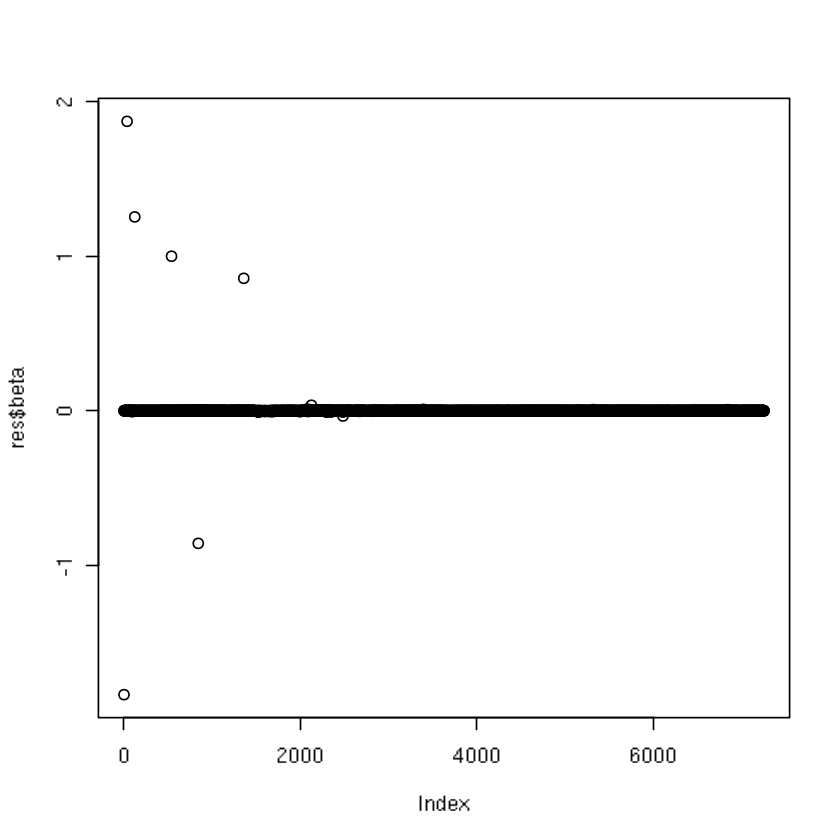

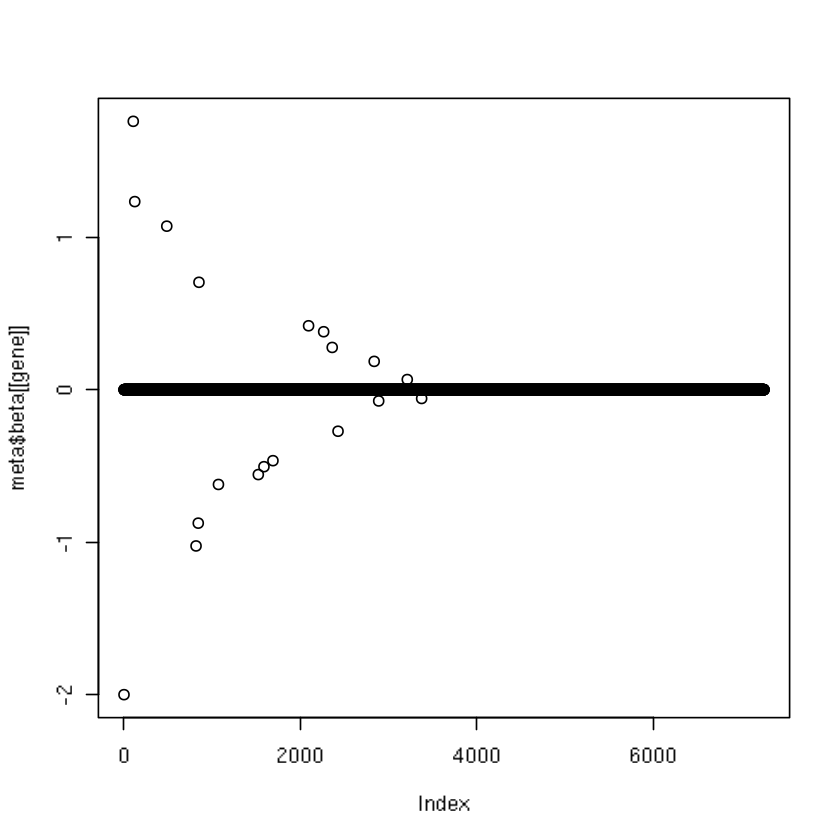

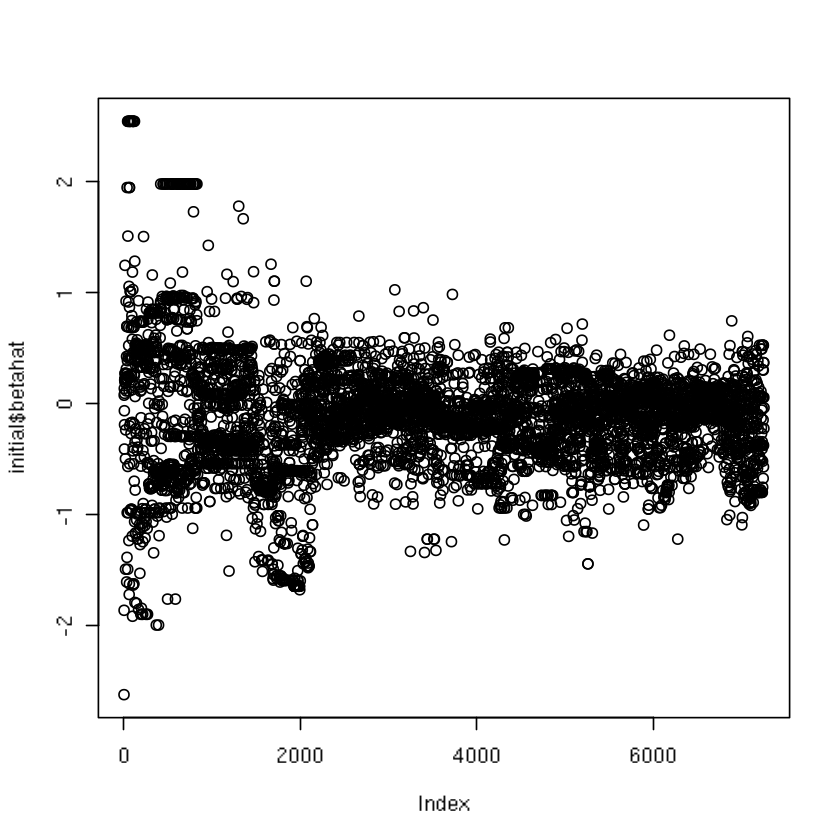

In [6]:
plot(res$beta)
plot(meta$beta[[gene]])
plot(initial$betahat)

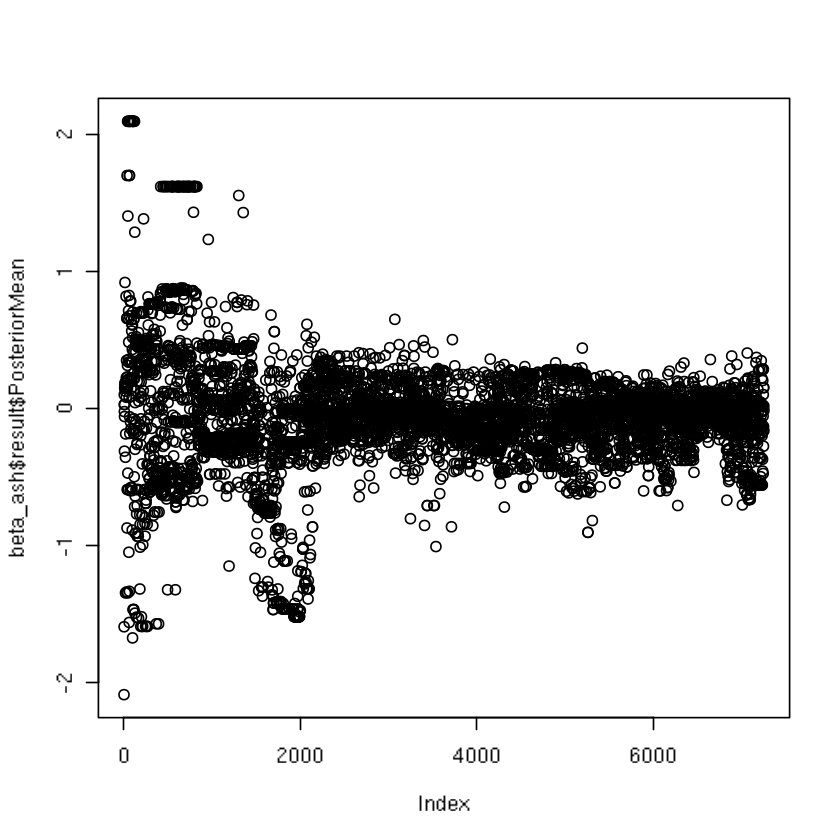

In [7]:
beta_ash = ashr::ash(initial$betahat,initial$sebetahat)
plot(beta_ash$result$PosteriorMean)

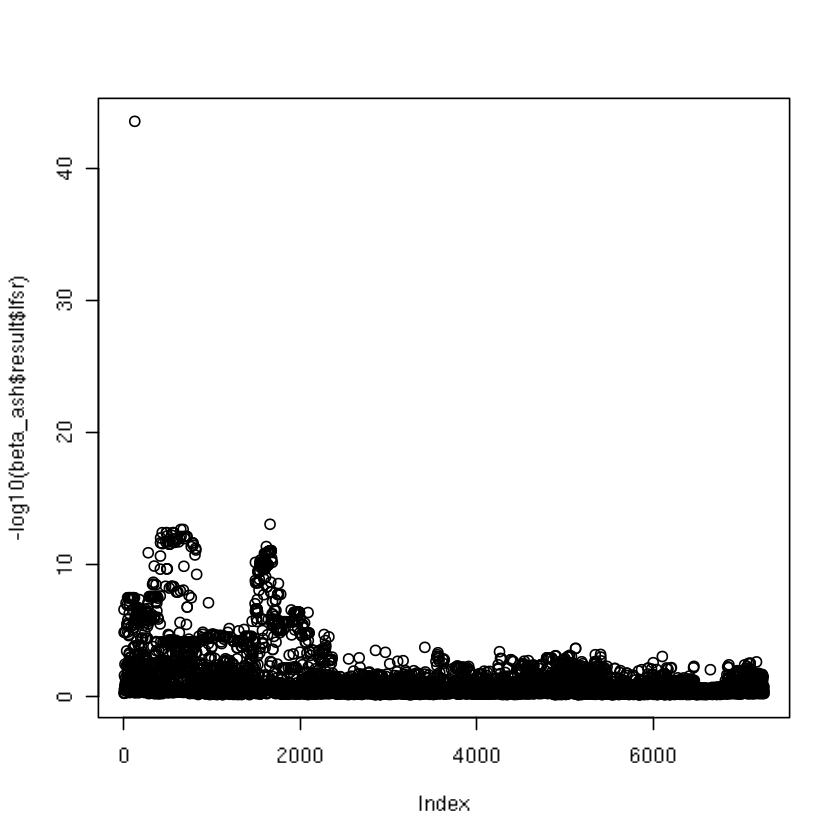

In [8]:
plot(-log10(beta_ash$result$lfsr))

0.7471395


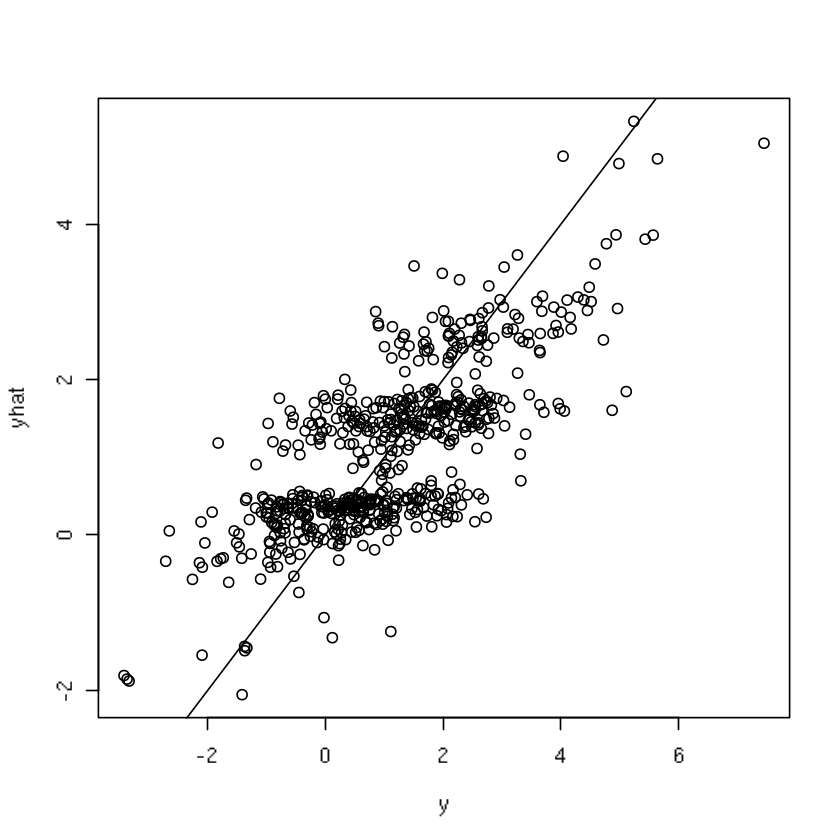

In [10]:
yhat = X %*% res$beta + res$mu.cov[1]
plot(y,yhat)
abline(0,1)
cor(y,yhat)